### carga de librerias.

In [14]:
import cv2
import cvlib as cv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib
import pandas as pd
import numpy as np

### Creación y entrenamiento del modelo base. 

In [15]:
#Genero el data set sintetico. 
def  generate_synthetic_data ( num_samples= 1000 ): 
    np.random.seed( 42 ) 
    emotions = [ 'feliz' , 'triste' , 'enojado' , 'neutral', 'sorprendido' ] 
    data = { 'image' : [], 'emotion' : []} 

    for _ in  range (num_samples): 
        
         image_data = np.random.rand( 100 , 100 , 3 ) * 255   
         emotion = np.random.choice(emotions) 
         data['image'].append(image_data) 
         data['emotion'].append(emotion) 

    df = pd.DataFrame(data) 
    return df

- **`num_samples` (valor predeterminado: 1000)**: especifica la cantidad de muestras a generar en el conjunto de datos sintéticos.  

- **`np.random.seed(42)`**: Establece la semilla para el generador de números aleatorios en NumPy para garantizar la reproducibilidad. La configuración de la semilla permite que otros reproduzcan el mismo conjunto de datos sintéticos utilizando la misma semilla.  

- Se define una matriz `emotions` que contiene cuatro etiquetas de emoción: `"feliz"`, `"triste"`, `"enojado"` y `"neutral"`. Estas etiquetas se asignarán aleatoriamente a las imágenes sintéticas.  

- Un diccionario `data` se inicializa con dos listas vacías: `'imagen'` para almacenar datos de imágenes sintéticas y `'emoción'` para almacenar las etiquetas de emoción correspondientes.  

- La función utiliza un bucle para generar datos sintéticos para la cantidad especificada de muestras (`num_samples`). Para cada iteración:  
  - **`image_data`**: se genera una imagen sintética aleatoria de forma `(100, 100, 3)`, que simula una imagen RGB de 100 x 100 con valores entre 0 y 255.  
  - **`emotion`**: se elige una etiqueta de emoción aleatoria de la lista definida de emociones utilizando `np.random.choice`.  
  - Los datos de imagen generados y la etiqueta de emoción correspondiente se agregan a las listas `'imagen'` y `'emoción'` en el diccionario `data`.  

- El diccionario de datos recopilado se utiliza para crear un **`pandas DataFrame`** (`df`), donde cada fila representa una muestra sintética con datos de imagen y etiqueta de emoción.  

- Finalmente, la función devuelve el conjunto de datos sintéticos como un **DataFrame de pandas**, lo que permite usarlo fácilmente para análisis posteriores, entrenamiento de modelos de aprendizaje automático u otras aplicaciones.  


In [16]:
# Generar datos de entrenamiento sintéticos
train_data = generate_synthetic_data() 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(train_data[ 'image' ], train_data[ 'emotion' ], test_size= 0.2 , random_state= 42 )

In [17]:
#Uso un modelo random forest pulido.
model = RandomForestClassifier(random_state=42, n_jobs=-1,
                               n_estimators=800, max_depth=12,
                               max_leaf_nodes=89, max_features=5,
                               min_samples_split=11,
                               min_samples_leaf=1,
                               min_impurity_decrease=0.0)

Antes de entrenar el modelo, debemos aplanar las imágenes.  

El modelo `RandomForestClassifier` espera características de entrada de números enteros no negativos, y el aplanamiento ayuda a lograrlo.  

Aquí, aplanamos cada imagen en el conjunto de entrenamiento, lo que da como resultado una matriz unidimensional.  


In [18]:
# Flatten (aplano las imagenes)
X_train_flat = [img.flatten() for img in X_train]

# entreno el modelo 
model.fit(X_train_flat, y_train)

RandomForestClassifier(max_depth=12, max_features=5, max_leaf_nodes=89,
                       min_samples_split=11, n_estimators=800, n_jobs=-1,
                       random_state=42)

In [19]:
# Guardo el modelo entrenado 
model_filename = 'medusa_b1.pkl' # creo una variable para nombrar el fichero y reutilizar el codigo más comodamente
joblib.dump(model, model_filename)
print(f"Trained model saved to {model_filename}")

Trained model saved to medusa_b1.pkl


### Grid search

#### Randon Search

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definir el modelo base
model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Espacio de búsqueda con menos combinaciones
param_dist = {
    'n_estimators': [500, 100, 150],   # Número de árboles
    'max_depth': [10, 12, 15],         # Profundidad máxima
    'max_leaf_nodes': [50, 89, 120],   # Máx. nodos hoja
    'max_features': [3, 5, 7],         # Características por nodo
    'min_samples_split': [5, 11, 15],  # Muestras mínimas para dividir
    'min_samples_leaf': [1, 3, 5],     # Muestras mínimas por hoja
}

# Configurar RandomizedSearchCV (10 iteraciones para reducir tiempo)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=10, cv=3, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

# Aplanar imágenes antes de entrenar
X_train_flat = [img.flatten() for img in X_train]

# Ejecutar búsqueda aleatoria
random_search.fit(X_train_flat, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor precisión:", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_leaf_nodes': 89, 'max_features': 5, 'max_depth': 10}
Mejor precisión: 0.23372100663644127


### Mediciones

Classification Report:
               precision    recall  f1-score   support

     enojado       0.25      0.28      0.27        46
       feliz       0.21      0.45      0.29        31
     neutral       0.25      0.06      0.09        36
 sorprendido       0.20      0.33      0.25        43
      triste       0.00      0.00      0.00        44

    accuracy                           0.21       200
   macro avg       0.18      0.22      0.18       200
weighted avg       0.18      0.21      0.17       200



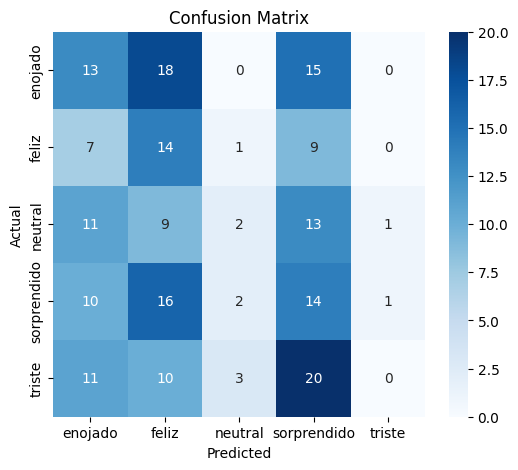

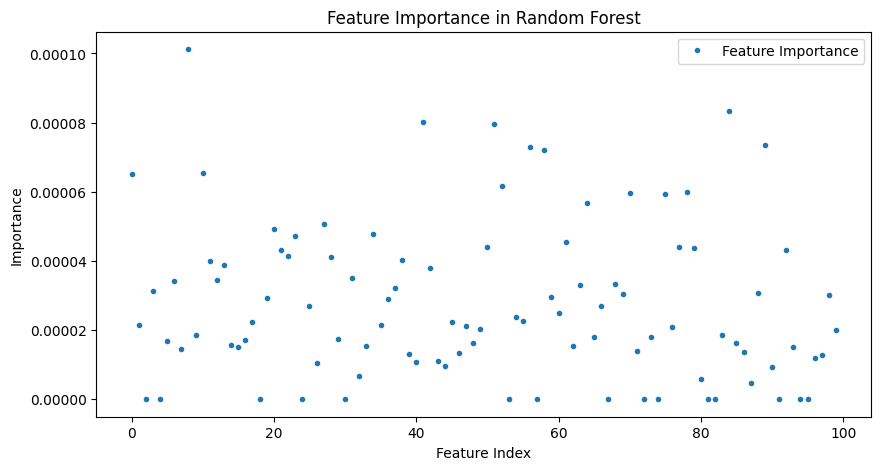

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Cargar el modelo entrenado
model = joblib.load('medusa_b1.pkl')

# Aplanar imágenes de prueba
X_test_flat = [img.flatten() for img in X_test]

# Hacer predicciones
y_pred = model.predict(X_test_flat)

# Imprimir métricas de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Importancia de características
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 5))
plt.plot(feature_importances[:100], marker='o', linestyle='', markersize=3, label="Feature Importance")  # Mostrar solo las primeras 100 para claridad
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.legend()
plt.show()


## Evaluación del Modelo Random Forest para Imágenes

### **Pasos de Evaluación**
1. **Aplanado de imágenes de prueba:**  
   - Las imágenes en su formato original son matrices 3D (`100x100x3`).  
   - Para que `RandomForestClassifier` pueda usarlas, se convierten en vectores 1D (`100*100*3 = 30,000` características).  

2. **Predicciones:**  
   - Se usa el modelo entrenado para predecir las etiquetas en el conjunto de prueba (`X_test`).  

3. **Cálculo de métricas:**  
   - Se genera un reporte con métricas de precisión, recall y F1-score (`classification_report`).  
   - Se crea una matriz de confusión para analizar los errores entre clases.  

4. **Visualización de la matriz de confusión:**  
   - Se usa `seaborn.heatmap` para mostrar la cantidad de predicciones correctas e incorrectas en cada clase.  

5. **Análisis de importancia de características:**  
   - Se grafica la importancia de los primeros 100 atributos del modelo.  
   - Aunque las imágenes contienen mucha información, algunas características pueden ser más relevantes que otras para la clasificación.  

---
### **Objetivo de la Evaluación**
- Verificar si el modelo ha aprendido correctamente a distinguir emociones.  
- Identificar clases con más errores para mejorar el preprocesamiento o ajustar hiperparámetros.  
- Analizar qué características visuales están influyendo más en la decisión del modelo.


---

### Bucle principal, detección de rostros, preprocesamiento y predicciones.

In [21]:
# Cargo el modelo
loaded_model = joblib.load(model_filename)

In [22]:
# Capturo video desde la cámara predeterminada (generalmente la cámara web incorporada usa el 0)
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Detect faces in the frame
    faces, confidences = cv.detect_face(frame)

    # Loop through detected faces
    for face, confidence in zip(faces, confidences):
        (start_x, start_y, end_x, end_y) = face

        # Crop the face from the frame
        face_crop = frame[start_y:end_y, start_x:end_x]

        # Resize the face for prediction (adjust the size as needed)
        face_resize = cv2.resize(face_crop, (100, 100))

        # Flatten the face image for prediction
        face_flat = face_resize.flatten()

        # Perform emotion prediction
        emotion = loaded_model.predict([face_flat])[0]

        # Draw bounding box and label on the frame
        label = f'Estas: {emotion}'
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        cv2.putText(frame, label, (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Emotion Detection', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()


- **`Bucle infinito`** el script utiliza un bucle infinito ( while True) para capturar y procesar continuamente fotogramas de vídeo hasta que el usuario decida salir.  

- **`Capturar fotograma`** ret, frame = `cap.read()` captura un fotograma de la fuente de vídeo (por ejemplo, cámara web). capes un objeto de captura de vídeo creado anteriormente en el código.  

- **`Detección de rostros`** faces, confidences = `cv.detect_face(frame)` utiliza la detect_facefunción de la biblioteca `cvlib`para identificar rostros en el cuadro capturado.  

- **`Bucle de procesamiento facial`** El script recorre cada rostro detectado, extrayendo las coordenadas del cuadro delimitador, recortando el rostro del marco y redimensionándolo a un tamaño fijo.  

- **`Predicción de emociones`** La imagen de la cara aplanada se utiliza como entrada para un modelo de aprendizaje automático previamente entrenado ( loaded_model) para predecir la emoción.  

- **`Dibujar un cuadro delimitador y una etiqueta`**  El script dibuja un cuadro delimitador alrededor de cada cara detectada y muestra la etiqueta de emoción prevista en el marco.  

- **`Mostrar fotograma resultante`** `cv2.imshow('Emotion Detection', frame)`muestra el fotograma resultante con cuadros delimitadores y etiquetas de emoción.  

- **`Romper el bucle`** El bucle se puede terminar si se presiona la tecla 'q' `( if cv2.waitKey(1) & 0xFF == ord('q'))`.  

- **`Recursos de liberación`** Después de salir del bucle, el objeto de captura de video se libera `( cap.release())` y todas las ventanas de OpenCV se cierran `( cv2.destroyAllWindows())`.  

El código captura básicamente fotogramas de vídeo, detecta rostros, predice emociones para cada rostro y muestra los resultados en tiempo real. El bucle continúa hasta que el usuario pulsa la tecla "q" para salir del programa.

---